In [486]:
import json


with open('/data/data.json', 'r') as file:
    data = json.load(file)

## Tg

### Love Rate

In [5]:
def love_rate(data):
    """
    Коэффициент привлекательности (Love Rate)
    (Количество лайков / Общее количество уникальных просмотров ) * 100%
    """
    total_views = 0
    total_likes = 0

    for i in data:
        for item in i['tg']:
            total_views += sum([0 if _["views"] is None else _["views"] for _ in item["posts"]])
            total_likes += sum([reaction["count"] for post in item["posts"] for reaction in post["reactions"] if reaction["emoji"] == "❤"])

    if total_views > 0 and total_likes > 0:
        love_rate = (total_likes / total_views) * 100
        return love_rate
    else:
        return 0
    
    
love_rate(data)

1.1029618652810864

### Engagement Rate 

In [6]:
def engagement_rate(data):
    '''
    Коэффициент вовлеченности (Engagement Rate)
    (Общее число взаимодействий / Общее число подписчиков) * 100%
    '''
    total_interactions = 0
    total_comments = 0

    for i in data:
        for item in i['tg']:
            followers = item['membersCount']
            likes = sum(reaction['count'] for post in item['posts'] for reaction in post['reactions'])
            reposts = sum(post['forwards'] for post in item['posts'])

            unique_sender_ids = set(comment['sender_id'] for post in item['posts'] for comment in post.get('replies', []))

            total_comments += len(unique_sender_ids)
            total_interactions += likes + total_comments + reposts

    if total_interactions > 0 and followers > 0:
        engagement_rate = (total_interactions / followers) * 100
        return engagement_rate
    else:
        return 0


engagement_rate(data)

0.9626264357963312

### Engagement Rate By Reach

In [23]:
def engagement_rate_by_reach(data):
    '''
    Коэффициент вовлеченности (Engagement Rate By Reach)
    (Общее число взаимодействий / Общее количество уникальных просмотров) * 100%
    '''
    total_interactions = 0
    total_comments = 0
    total_views = 0

    for i in data:
        for item in i['tg']:
            total_views += sum([0 if _["views"] is None else _["views"] for _ in item["posts"]])
            
            likes = sum(reaction['count'] for post in item['posts'] for reaction in post['reactions'])
            reposts = sum(post.get('forwards', 0) for post in item['posts'])  

            unique_sender_ids = set(comment['sender_id'] for post in item['posts'] for comment in post.get('replies', []))

            total_comments += len(unique_sender_ids)
            total_interactions += likes + total_comments + reposts

    if total_interactions > 0 and total_views > 0:
        engagement_rate_by_reach = (total_interactions / total_views) * 100
        return engagement_rate_by_reach
    else:
        return 0


engagement_rate_by_reach(data)

2.106507099848061

### Показатель аудиторного охвата

In [65]:
from datetime import datetime


def audience_coverage(data):
    '''
    Показатель аудиторного охвата (Audience Coverage)
    (Количество лайков/просмотров/репостов/комментариев уникальных пользователей) / (Количество дней рассматриваемого периода) 
    '''
    for i in data:
        for item in i['tg']:
            total_interactions = item["membersCount"]
            
            start_date = datetime.strptime(item["from"], "%d/%m/%Y")
            end_date = datetime.strptime(item["to"], "%d/%m/%Y")
            days_between = (end_date - start_date).days
                
    if total_interactions > 0 and days_between > 0:
        audience_coverage = (total_interactions / days_between) 
        return int(audience_coverage)
    else:
        return 0
    
    
audience_coverage(data)

23332

### Channel Citation Index

In [77]:
def channel_citation_index(data):
    """
    Индекс цитируемости (Channel Citation Index)
    (Количество репостов / Общее количество уникальных просмотров) * 100%
    """
    total_views = 0
    total_reposts = 0

    for i in data:
        for item in i['tg']:
            valid_posts = [post for post in item["posts"] if post["views"] is not None] 
            total_views += sum([post["views"] for post in valid_posts])
            total_reposts = sum(post.get('forwards', 0) for post in item['posts'])  

    if total_views > 0 and total_reposts > 0:
        channel_citation_index = (total_reposts / total_views) * 100
        return channel_citation_index
    else:
        return 0
    
    
channel_citation_index(data)

0.25698261146855245

### Discussion Rate

In [127]:
def discussion_rate(data):
    """
    Обсуждаемость постов (Discussion Rate)
    (Количество подкомментариев) / (Количество уникальных пользователей в подкомментариях) * 100% 
    """
    for i in data:
        for item in i['tg']:
            comment = [comment['sender_id'] for post in item['posts'] for comment in post.get('replies', [])]
            
            total_comment = len(comment)
            unique_sender_ids = len(set(comment))
            
    if unique_sender_ids == 1:
        return 1
    else:
        discussion_rate = (total_comment / unique_sender_ids) * 100
        return discussion_rate
            

discussion_rate(data)

150.0

### Sentimental Analysis for messages

In [8]:
from transformers import pipeline


def top_regions(data):
    '''
    Топ-20 регионов с наибольшим числом пользователей
    [регион | пользователей | % | тональность]
    '''
    # https://huggingface.co/blanchefort/rubert-base-cased-sentiment модель для анализа тональности
    classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment") 

    city_users = {}

    total_users = 0
    
    for i in data:
        for item in i['tg']:
            for post in item['posts']:
                for reply in post.get('replies', []):
                    city = reply.get('city', 'Unknown')
                    if city not in city_users:
                        city_users[city] = []
                    city_users[city].append(reply['sender_id'])
                    total_users += 1

    city_stats = {}
    for city, users in city_users.items():
        users_count = len(users)
        percent = (users_count / total_users) * 100

        user_messages = [post['text'] for post in item['posts'] for post in post['replies'] if post.get('city') == city and post['text'] is not None]
        classified_messages = classifier(user_messages)
        len_messages = len(classified_messages)
        positive = len([i for i in classified_messages if i['label']=='POSITIVE']) / len_messages
        negative = len([i for i in classified_messages if i['label']=='NEGATIVE']) / len_messages
        neutral = len([i for i in classified_messages if i['label']=='NEUTRAL']) / len_messages

        city_stats[city] = {
            'users_count': users_count,
            'percent': percent,
            'user_messages': user_messages,
            'positive': positive,
            'negative': negative,
            'neutral': neutral
        }

    # Оставляем топ-20, сортируем city_stats по users_count 
    sorted_city_stats = dict(sorted(city_stats.items(), key=lambda x: x[1]['users_count'], reverse=True)[:20])

    top_regions = json.dumps(sorted_city_stats, indent=4, ensure_ascii=False)
    return top_regions


result = top_regions(data)
print(result)

{
    "null": {
        "users_count": 9,
        "percent": 100.0,
        "user_messages": [
            "А почему у вас нет воды легенда гор в 19 литровых бутылках?))",
            "Бенто со сгущенкой",
            "О, словечки вернулись",
            "Добрый день, Алина",
            "Полностью поддерживаем вас в этом выборе",
            "Я на хлебной планете уже 7 лет)",
            "Любимое мороженое. И на Пломбирной планете можно было бы пополнять бесконечно ведерко",
            "Промокодов для постоянных клиентов давно не было("
        ],
        "positive": 0.125,
        "negative": 0.125,
        "neutral": 0.75
    }
}


### Net Promoter Score

In [113]:
from transformers import pipeline


def net_promoter_score(data):
    """
    Лояльность пользователей (Net Promoter Score)
    ((Положительные комментарии - Негативные комментарии) / Всего комментариев) * 100%
    """
    classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment") 

    for i in data:
        for item in i['tg']:
            total_messages = [post['text'] for post in item['posts'] for post in post['replies'] if post['text'] is not None]
            print(total_messages)
            len_total_messages = len(total_messages)
            
            classified_messages = classifier(total_messages)
            positive_count = sum(1 for i in classified_messages if i['label'] == 'POSITIVE')
            negative_count = sum(1 for i in classified_messages if i['label'] == 'NEGATIVE')

    if len_total_messages > 0:
        net_promoter_score = ((positive_count - negative_count) / len_total_messages) * 100
        return net_promoter_score
    else:
        return 0
    
    
net_promoter_score(data)

['А почему у вас нет воды легенда гор в 19 литровых бутылках?))', 'Бенто со сгущенкой', 'О, словечки вернулись', 'Добрый день, Алина', 'Полностью поддерживаем вас в этом выборе', 'Я на хлебной планете уже 7 лет)', 'Любимое мороженое. И на Пломбирной планете можно было бы пополнять бесконечно ведерко', 'Промокодов для постоянных клиентов давно не было(']


0.0

### Тональность комментариев по длине символов

In [195]:
from transformers import pipeline


def character_length(data):
    '''
    Распределение тональности комментариев по длине символов
    [количество символов | тональность]
    '''
    lists = []
    results = []
    
    # https://huggingface.co/blanchefort/rubert-base-cased-sentiment модель для анализа тональности
    classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment") 
    
    # диапазоны длин символов
    dict_lengths = {1: '0-10', 2: '11-50', 3: '51-100', 4: '101-200', 5: '201+'}

    comments_lengths = {
        dict_lengths[1]: [],
        dict_lengths[2]: [],
        dict_lengths[3]: [],
        dict_lengths[4]: [],
        dict_lengths[5]: [] 
    }

    for group in data:
        for post in group['tg'][0]['posts']:
            for reply in post['replies']:
                if reply['text'] != None:
                    comment_length = len(reply['text'])
                    if comment_length < int(dict_lengths[1].split('-')[1])+1:
                        comments_lengths[dict_lengths[1]].append(reply['text'])
                    elif int(dict_lengths[1].split('-')[1])+1 <= comment_length <= int(dict_lengths[2].split('-')[1])+1:
                        comments_lengths[dict_lengths[2]].append(reply['text'])
                    elif int(dict_lengths[2].split('-')[1])+1 <= comment_length <= int(dict_lengths[3].split('-')[1])+1:
                        comments_lengths[dict_lengths[3]].append(reply['text'])
                    elif int(dict_lengths[3].split('-')[1])+1 <= comment_length <= int(dict_lengths[4].split('-')[1])+1:
                        comments_lengths[dict_lengths[4]].append(reply['text'])
                    else:
                        comments_lengths[dict_lengths[5]].append(reply['text'])

    for lengths in comments_lengths.keys():
        lists.append([classifier(_) for _ in comments_lengths[lengths]])
        
    length_keys = dict_lengths.values()

    for list in lists:
        total_score = sum(dict['score'] for sublist in list for dict in sublist)

        distribution = {'positive': 0, 'negative': 0, 'neutral': 0} 
        if total_score != 0:
            for sublist in list:
                for dict in sublist:
                    distribution[dict['label'].lower()] += (dict['score'] / total_score) * 100

        results.append(distribution)

    comments_lengths_sentimentary = {}
    for i, dist in zip(length_keys, results):
        comments_lengths_sentimentary[i] = dist

    return comments_lengths_sentimentary


character_length(data)

{'0-10': {'positive': 0, 'negative': 0, 'neutral': 0},
 '11-50': {'positive': 0,
  'negative': 19.524068842154584,
  'neutral': 80.47593115784542},
 '51-100': {'positive': 54.90797873326216,
  'negative': 0,
  'neutral': 45.092021266737845},
 '101-200': {'positive': 0, 'negative': 0, 'neutral': 0},
 '201+': {'positive': 0, 'negative': 0, 'neutral': 0}}

### Топ эмодзи

In [16]:
def top_emoji(data):
    '''
    Топ-5 эмодзи
    [эмодзи | количество упоминаний эмодзи]
    '''
    reactions_summary = {}
    
    for group in data:
        posts = (post_item for item in group['tg'] for post_item in item['posts'])
        
        for post_item in posts:
            reactions = post_item.get('reactions', {})
            
            if reactions is not None:
                for reaction in filter(lambda r: r['emoji'] is not None, reactions):
                    emoji = reaction['emoji']
                    count = reaction['count']
                    
                    reactions_summary[emoji] = reactions_summary.get(emoji, 0) + count

    top_reactions = dict(sorted(reactions_summary.items(), key=lambda x: x[1], reverse=True)[:5])
    return top_reactions  
    
    
top_emoji(data)

{'❤': 588, '👍': 82, '🔥': 74, '🤣': 71, '👎': 36}

## ВКонтакте

### Love Rate

In [19]:
def love_rate(data):
    """
    Коэффициент привлекательности (Love Rate)
    (Количество лайков / Общее количество уникальных просмотров) * 100%
    """
    total_views = 0
    total_likes = 0

    for i in data:
        for item in i['vk']:
            valid_posts = [post for post in item["posts"] if post["views"] is not None] # только те посты, где просмотры != None
            total_views += sum([post["views"] for post in valid_posts])
            total_likes += sum([reaction["count"] for post in valid_posts for reaction in post["reactions"] if reaction["emoji"] == "like"])

    if total_views > 0 and total_likes > 0:
        love_rate = (total_likes / total_views) * 100
        return love_rate
    else:
        return 0
    
    
love_rate(data)

35.0

### Engagement Rate 

In [29]:
def engagement_rate(data):
    '''
    Коэффициент вовлеченности (Engagement Rate)
    (Общее число взаимодействий / Общее число подписчиков) * 100%
    '''
    total_interactions = 0
    total_comments = 0

    for i in data:
        for item in i['vk']:
            followers = item['membersCount']
            likes = sum(reaction['count'] for post in item['posts'] for reaction in post['reactions'])
            reposts = sum(post['forwards'] for post in item['posts'])

            unique_sender_ids = set(comment['sender_id'] for post in item['posts'] for comment in post.get('replies', []))

            total_comments += len(unique_sender_ids)
            total_interactions += likes + total_comments + reposts

    if total_interactions > 0 and followers > 0:
        engagement_rate = (total_interactions / followers) * 100
        return engagement_rate
    else:
        return 0


engagement_rate(data)

0.135772935928105

### Engagement Rate By Reach

In [22]:
def engagement_rate_by_reach(data):
    '''
    Коэффициент вовлеченности (Engagement Rate By Reach)
    (Общее число взаимодействий / Общее количество уникальных просмотров) * 100%
    '''
    total_interactions = 0
    total_comments = 0
    total_views = 0

    for i in data:
        for item in i['vk']:
            valid_posts = [post for post in item["posts"] if post["views"] is not None] 
            total_views += sum([post["views"] for post in valid_posts])
            
            likes = sum(reaction['count'] for post in item['posts'] for reaction in post['reactions'])
            reposts = sum(post.get('forwards', 0) for post in item['posts'])  

            unique_sender_ids = set(comment['sender_id'] for post in item['posts'] for comment in post.get('replies', []))

            total_comments += len(unique_sender_ids)
            total_interactions += likes + total_comments + reposts

    if total_interactions > 0 and total_views > 0:
        engagement_rate_by_reach = (total_interactions / total_views) * 100
        return engagement_rate_by_reach
    else:
        return 0


engagement_rate_by_reach(data)

87.5

### Показатель аудиторного охвата

In [78]:
from datetime import datetime


def audience_coverage(data):
    '''
    Показатель аудиторного охвата (Audience Coverage)
    (Уникальные пользователи (Количество лайков + количество просмотров + количество репостов + количестко комментариев + 
    количество лайков комментариев)) / (Количество дней рассматриваемого периода) 
    '''
    total_interactions = 0
    total_comments = 0
    total_views = 0

    for i in data:
        for item in i['vk']:
            valid_posts = [post for post in item["posts"] if post["views"] is not None] 
            total_views += sum([post["views"] for post in valid_posts])
            
            likes_comments = sum([reaction['count'] for post in item['posts'] for comment in post.get('replies', []) for reaction in comment.get('reactions', [])])
            total_likes = sum(reaction['count'] for post in item['posts'] for reaction in post['reactions']) + likes_comments
            
            reposts = sum(post.get('forwards', 0) for post in item['posts'])  

            unique_sender_ids = set(comment['sender_id'] for post in item['posts'] for comment in post.get('replies', []))

            total_comments += len(unique_sender_ids)
            total_interactions += total_likes + total_comments + reposts + total_views
            
            start_date = datetime.strptime(item["from"], "%d/%m/%Y")
            end_date = datetime.strptime(item["to"], "%d/%m/%Y")
            days_between = (end_date - start_date).days
                
    if total_interactions > 0 and days_between > 0:
        audience_coverage = (total_interactions / days_between) 
        return int(audience_coverage)
    else:
        return 0
    
    
audience_coverage(data)

52

### Channel Citation Index

In [79]:
def channel_citation_index(data):
    """
    Индекс цитируемости (Channel Citation Index)
    (Количество репостов / Общее количество уникальных просмотров) * 100%
    """
    total_views = 0
    total_reposts = 0

    for i in data:
        for item in i['vk']:
            valid_posts = [post for post in item["posts"] if post["views"] is not None] 
            total_views += sum([post["views"] for post in valid_posts])
            total_reposts = sum(post.get('forwards', 0) for post in item['posts'])  

    if total_views > 0 and total_reposts > 0:
        channel_citation_index = (total_reposts / total_views) * 100
        return channel_citation_index
    else:
        return 0
    
    
channel_citation_index(data)

0

### Discussion Rate

In [128]:
def discussion_rate(data):
    """
    Обсуждаемость постов (Discussion Rate)
    (Количество подкомментариев / Количество уникальных пользователей в подкомментариях) * 100% 
    """
    for i in data:
        for item in i['vk']:
            comment = [comment['sender_id'] for post in item['posts'] for comment in post.get('replies', [])]
            
            total_comment = len(comment)
            unique_sender_ids = len(set(comment))
            
    if unique_sender_ids == 1:
        return 1
    else:
        discussion_rate = (total_comment / unique_sender_ids) * 100
        return discussion_rate
            

discussion_rate(data)

114.28571428571428

### Sentimental Analysis for messages

In [28]:
from transformers import pipeline


def top_regions(data):
    '''
    Топ-20 регионов с наибольшим числом пользователей
    [регион | пользователей | % | тональность]
    '''
    # https://huggingface.co/blanchefort/rubert-base-cased-sentiment модель для анализа тональности
    classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment") 

    city_users = {}

    total_users = 0
    
    for i in data:
        for item in i['vk']:
            for post in item['posts']:
                for reply in post.get('replies', []):
                    city = reply.get('city', 'Unknown')
                    if city not in city_users:
                        city_users[city] = []
                    city_users[city].append(reply['sender_id'])
                    total_users += 1

    city_stats = {}
    for city, users in city_users.items():
        users_count = len(users)
        percent = (users_count / total_users) * 100

        user_messages = [post['text'] for post in item['posts'] for post in post['replies'] if post.get('city') == city and post['text'] is not None]
        classified_messages = classifier(user_messages)
        len_messages = len(classified_messages)
        positive = len([i for i in classified_messages if i['label']=='POSITIVE']) / len_messages
        negative = len([i for i in classified_messages if i['label']=='NEGATIVE']) / len_messages
        neutral = len([i for i in classified_messages if i['label']=='NEUTRAL']) / len_messages

        city_stats[city] = {
            'users_count': users_count,
            'percent': percent,
            'user_messages': user_messages,
            'positive': positive,
            'negative': negative,
            'neutral': neutral
        }

    # Оставляем топ-20, сортируем city_stats по users_count 
    sorted_city_stats = dict(sorted(city_stats.items(), key=lambda x: x[1]['users_count'], reverse=True)[:20])

    top_regions = json.dumps(sorted_city_stats, indent=4, ensure_ascii=False)
    return top_regions


result = top_regions(data)
print(result)

{
    "Москва": {
        "users_count": 4,
        "percent": 50.0,
        "user_messages": [
            "Мы только первую быстро скушали, а после второй решили, что наелись и больше не хотим 😂",
            "Надо брать однозначно",
            "Пойду запускать ракету всем хорошего вечера и до новых встреч",
            "Сказочное фото, спокойной ночи"
        ],
        "positive": 0.5,
        "negative": 0.25,
        "neutral": 0.25
    },
    "Санкт-Петербург": {
        "users_count": 1,
        "percent": 12.5,
        "user_messages": [
            "Мне они тоже понравились"
        ],
        "positive": 1.0,
        "negative": 0.0,
        "neutral": 0.0
    },
    "Балашиха": {
        "users_count": 1,
        "percent": 12.5,
        "user_messages": [
            "У нас тоже быстро закончилось."
        ],
        "positive": 0.0,
        "negative": 1.0,
        "neutral": 0.0
    },
    "null": {
        "users_count": 1,
        "percent": 12.5,
        "user_messa

### Net Promoter Score

In [107]:
from transformers import pipeline


def net_promoter_score(data):
    """
    Лояльность пользователей (Net Promoter Score)
    ((Положительные комментарии - Негативные комментарии) / Всего комментариев) * 100%
    """
    # https://huggingface.co/blanchefort/rubert-base-cased-sentiment модель для анализа тональности
    classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment") 

    for i in data:
        for item in i['vk']:
            total_messages = [post['text'] for post in item['posts'] for post in post['replies'] if post['text'] is not None]
            len_total_messages = len(total_messages)
            
            classified_messages = classifier(total_messages)
            positive_count = sum(1 for i in classified_messages if i['label'] == 'POSITIVE')
            negative_count = sum(1 for i in classified_messages if i['label'] == 'NEGATIVE')

    if len_total_messages > 0:
        net_promoter_score = ((positive_count - negative_count) / len_total_messages) * 100
        return net_promoter_score
    else:
        return 0
    
    
net_promoter_score(data)

37.5

### Тональность комментариев по длине символов

In [196]:
from transformers import pipeline


def character_length(data):
    '''
    Распределение тональности комментариев по длине символов
    [количество символов | тональность]
    '''
    lists = []
    results = []
    
    # https://huggingface.co/blanchefort/rubert-base-cased-sentiment модель для анализа тональности
    classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment") 
    
    # диапазоны длин символов
    dict_lengths = {1: '0-10', 2: '11-50', 3: '51-100', 4: '101-200', 5: '201+'}

    comments_lengths = {
        dict_lengths[1]: [],
        dict_lengths[2]: [],
        dict_lengths[3]: [],
        dict_lengths[4]: [],
        dict_lengths[5]: [] 
    }

    for group in data:
        for post in group['vk'][0]['posts']:
            for reply in post['replies']:
                if reply['text'] != None:
                    comment_length = len(reply['text'])
                    if comment_length < int(dict_lengths[1].split('-')[1])+1:
                        comments_lengths[dict_lengths[1]].append(reply['text'])
                    elif int(dict_lengths[1].split('-')[1])+1 <= comment_length <= int(dict_lengths[2].split('-')[1])+1:
                        comments_lengths[dict_lengths[2]].append(reply['text'])
                    elif int(dict_lengths[2].split('-')[1])+1 <= comment_length <= int(dict_lengths[3].split('-')[1])+1:
                        comments_lengths[dict_lengths[3]].append(reply['text'])
                    elif int(dict_lengths[3].split('-')[1])+1 <= comment_length <= int(dict_lengths[4].split('-')[1])+1:
                        comments_lengths[dict_lengths[4]].append(reply['text'])
                    else:
                        comments_lengths[dict_lengths[5]].append(reply['text'])

    for lengths in comments_lengths.keys():
        lists.append([classifier(_) for _ in comments_lengths[lengths]])
        
    length_keys = dict_lengths.values()

    for list in lists:
        total_score = sum(dict['score'] for sublist in list for dict in sublist)

        distribution = {'positive': 0, 'negative': 0, 'neutral': 0} 
        if total_score != 0:
            for sublist in list:
                for dict in sublist:
                    distribution[dict['label'].lower()] += (dict['score'] / total_score) * 100

        results.append(distribution)

    comments_lengths_sentimentary = {}
    for i, dist in zip(length_keys, results):
        comments_lengths_sentimentary[i] = dist

    return comments_lengths_sentimentary


character_length(data)

{'0-10': {'positive': 0, 'negative': 0, 'neutral': 0},
 '11-50': {'positive': 54.046635553825936,
  'negative': 21.95435574663157,
  'neutral': 23.9990086995425},
 '51-100': {'positive': 78.39615016850013,
  'negative': 21.60384983149988,
  'neutral': 0},
 '101-200': {'positive': 0, 'negative': 0, 'neutral': 0},
 '201+': {'positive': 0, 'negative': 0, 'neutral': 0}}

### Топ эмодзи

In [31]:
import emoji
from collections import Counter


def top_emoji(data):
    '''
    Топ-5 эмодзи
    [эмодзи | количество упоминаний эмодзи в комментариях]
    '''
    def extract_emojis(text):
        return ''.join(c for c in text if emoji.is_emoji(c))

    emoji_counter = Counter()

    for group in data:
        for item in group['vk']:

            messages = (reply['text'] for post in item['posts'] 
                        for reply in post['replies'] if reply['text'] is not None)
            
            for message in messages:
                emojis = extract_emojis(message)
                emoji_counter.update(emojis)

    top_emojis = dict(emoji_counter.most_common(5))       
    return top_emojis  


top_emoji(data)

{'👎': 2, '🔥': 1, '❤': 1, '😂': 1, '⚡': 1}

## Общие метрики

### PageRank

In [63]:
# Example data
from faker import Faker
import networkx as nx
import matplotlib.pyplot as plt
import random

sender_id = list(range(108718, 109718)) # узлы
connections = [(random.choice(sender_id), random.choice(sender_id)) for _ in range(len(sender_id))] # ребра

fake = Faker()

example_data = {}
for id in sender_id:
    example_data[id] = {"first_name": fake.first_name(), "last_name": fake.last_name()}


print(sender_id, example_data, connections, sep='\n')

[108718, 108719, 108720, 108721, 108722, 108723, 108724, 108725, 108726, 108727, 108728, 108729, 108730, 108731, 108732, 108733, 108734, 108735, 108736, 108737, 108738, 108739, 108740, 108741, 108742, 108743, 108744, 108745, 108746, 108747, 108748, 108749, 108750, 108751, 108752, 108753, 108754, 108755, 108756, 108757, 108758, 108759, 108760, 108761, 108762, 108763, 108764, 108765, 108766, 108767, 108768, 108769, 108770, 108771, 108772, 108773, 108774, 108775, 108776, 108777, 108778, 108779, 108780, 108781, 108782, 108783, 108784, 108785, 108786, 108787, 108788, 108789, 108790, 108791, 108792, 108793, 108794, 108795, 108796, 108797, 108798, 108799, 108800, 108801, 108802, 108803, 108804, 108805, 108806, 108807, 108808, 108809, 108810, 108811, 108812, 108813, 108814, 108815, 108816, 108817, 108818, 108819, 108820, 108821, 108822, 108823, 108824, 108825, 108826, 108827, 108828, 108829, 108830, 108831, 108832, 108833, 108834, 108835, 108836, 108837, 108838, 108839, 108840, 108841, 108842,

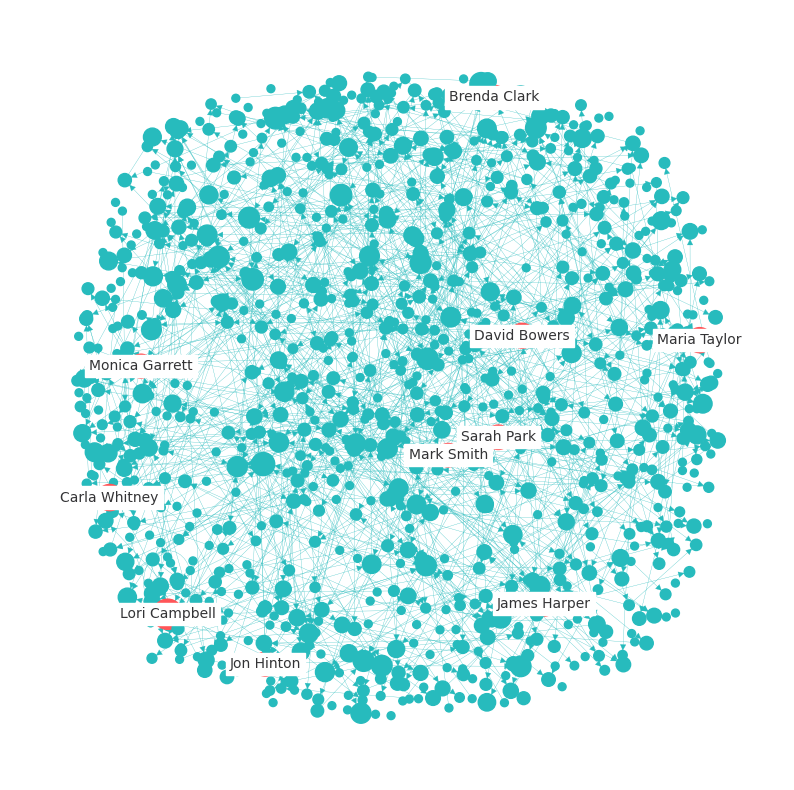

{'Lori Campbell': 0.00674, 'Carla Whitney': 0.00508, 'James Harper': 0.0047, 'Maria Taylor': 0.00467, 'David Bowers': 0.00458, 'Sarah Park': 0.00443, 'Jon Hinton': 0.0043, 'Brenda Clark': 0.00427, 'Monica Garrett': 0.00421, 'Mark Smith': 0.00409}


In [75]:
def page_rank(sender_id, example_data, connections):
    '''
    Топ-10 авторов с наибольшей способностью вовлекать других пользователей в дискуссию
    [пользователь | значение page rank]
    
    sender_id - узлы (id пользователей)
    example_data - (словарь с id в качестве ключа и значений в качестве словаря из first_name и last_name)
    connections - ребра (one-to-one = id-to-id)
    '''
    G = nx.DiGraph()
    [G.add_node(k, first_name = example_data[k]['first_name'], last_name = example_data[k]['last_name']) for k in sender_id]
    G.add_edges_from(connections)
    # spring_layout - https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
    pos = nx.spring_layout(G, k=0.15, iterations=20) 

    # pagerank - https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html
    pr = nx.pagerank(G)
    sorted_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)

    top_10 = sorted_pr[:10] 
    top_10_ids = [id for id, pr in top_10]
    # топ 10 пользователей с наибольшим pagerank
    top_nodes = {node: G.nodes[node]['first_name'] + ' ' + G.nodes[node]['last_name'] for node in dict(top_10).keys()} 

    # для графа
    node_colors = ['#FF5558' if node in top_10_ids else "#27BBBD" for node in G.nodes()]
    plt.figure(figsize = (10, 10)) 
    nx.draw_networkx_labels(G, pos, 
                            labels = top_nodes, 
                            font_color = '#333335', 
                            font_size = 10, 
                            bbox = dict(facecolor='white', edgecolor='white', boxstyle='square'))
    nx.draw(G, pos, 
            nodelist = list(pr.keys()), 
            node_size = [v * 70000 for v in pr.values()], 
            with_labels = False, 
            node_color = node_colors, 
            edge_color = '#27BBBD', 
            width = 0.2)
    plt.show()

    # для таблицы "Top 20 influencers by Page Rank"
    name_surname_dict = {example_data[k]['first_name'] + ' ' + example_data[k]['last_name']: round(v, 5) for k, v in top_10}
    print(name_surname_dict)
    
    
page_rank(sender_id, example_data, connections)

### Betweenness Centrality

In [ ]:
# Example data
from faker import Faker
import networkx as nx
import matplotlib.pyplot as plt
import random

sender_id = list(range(108718, 109718)) # узлы
connections = [(random.choice(sender_id), random.choice(sender_id)) for _ in range(len(sender_id))] # ребра

fake = Faker()

example_data = {}
for id in sender_id:
    example_data[id] = {"first_name": fake.first_name(), "last_name": fake.last_name()}


print(sender_id, example_data, connections, sep='\n')

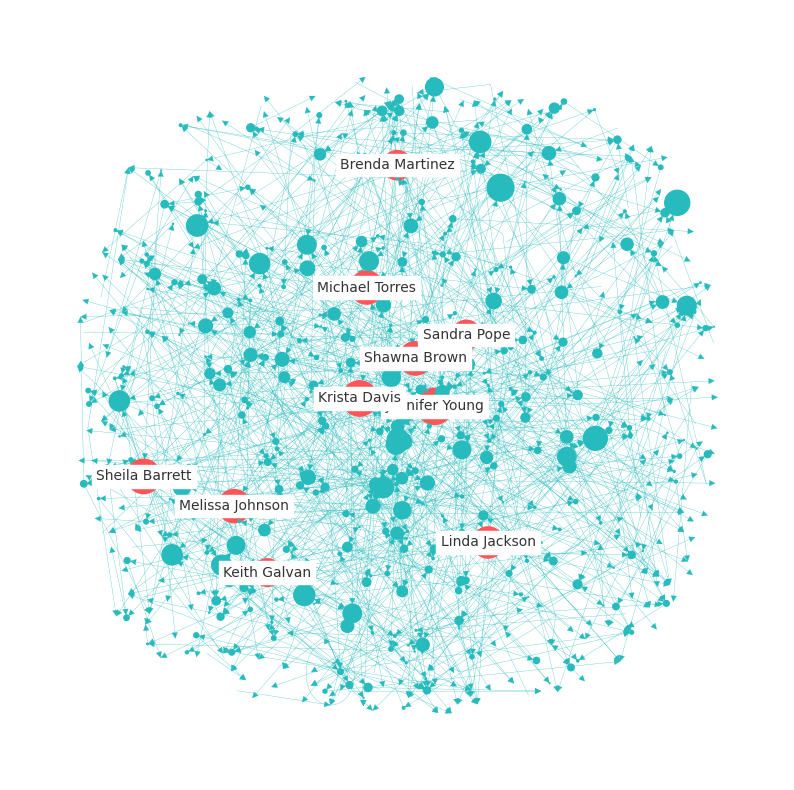

{'Jennifer Young': 0.00225, 'Krista Davis': 0.00217, 'Sheila Barrett': 0.00203, 'Shawna Brown': 0.00192, 'Michael Torres': 0.0019, 'Melissa Johnson': 0.00189, 'Linda Jackson': 0.00168, 'Brenda Martinez': 0.00148, 'Sandra Pope': 0.00147, 'Keith Galvan': 0.00132}


In [74]:
def betweenness_centrality_rank(sender_id, example_data, connections):
    '''
    Топ-10 авторов с наибольшей способностью связывать подсети других пользователей в графе
    [пользователь | значение betweenness centrality rank]
    
    sender_id - узлы (id пользователей)
    example_data - (словарь с id в качестве ключа и значений в качестве словаря из first_name и last_name)
    connections - ребра (one-to-one = id-to-id)
    '''
    G = nx.DiGraph()
    [G.add_node(k, first_name = example_data[k]['first_name'], last_name = example_data[k]['last_name']) for k in sender_id]
    G.add_edges_from(connections)
    pos = nx.spring_layout(G, k=0.15, iterations=20)

    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html
    centrality = nx.betweenness_centrality(G)
    sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

    top_10 = sorted_centrality[:10] 
    top_10_ids = [id for id, _ in top_10]
    top_nodes = {node: G.nodes[node]['first_name'] + ' ' + G.nodes[node]['last_name'] for node in dict(top_10).keys()} 

    node_colors = ['#FF5558' if node in top_10_ids else '#27BBBD' for node in G.nodes()]
    plt.figure(figsize = (10, 10)) 
    nx.draw_networkx_labels(G, pos, 
                            labels = top_nodes, 
                            font_color = '#333335', 
                            font_size = 10, 
                            bbox = dict(facecolor='white', edgecolor='white', boxstyle='square'))
    nx.draw(G, pos, 
            nodelist = list(centrality.keys()), 
            node_size = [v * 300000 for v in centrality.values()], 
            with_labels = False, 
            node_color = node_colors, 
            edge_color = '#27BBBD', 
            width = 0.2)
    plt.show()

    # для таблицы "Top 20 influencers by Betweenness Centrality Rank"
    name_surname_dict = {example_data[k]['first_name'] + ' ' + example_data[k]['last_name']: round(v, 5) for k, v in top_10}
    print(name_surname_dict)


betweenness_centrality_rank(sender_id, example_data, connections)

### Топ-5 авторов с наибольшим числом сообщений

In [162]:
# Example data
from faker import Faker
import random

fake = Faker()

data = {}
followers = random.randint(400, 600)  
possible_comments = ['Супер', 'Было вкусно', 'Обожаю', 'Отлично', 'Превосходно', 'Не понравилось', 'Интересно']
num_comments = random.randint(3, 5)

for i in range(108718, 108800):  
    first_name = fake.first_name()
    last_name = fake.last_name()
    messages = random.randint(30, 60)
    likes = random.randint(50, 120)
    comments = [random.choice(possible_comments) for _ in range(num_comments)]
    reposts = random.randint(10, 25)

    data[i] = {"first_name": first_name, "last_name": last_name, 
               "messages": messages, "likes": likes, "comments": comments, 
               "reposts": reposts, "followers": followers}
    
list(data.items())[:3]

[(108718,
  {'first_name': 'Aaron',
   'last_name': 'Brewer',
   'messages': 30,
   'likes': 58,
   'comments': ['Интересно', 'Было вкусно', 'Было вкусно', 'Отлично'],
   'reposts': 10,
   'followers': 568}),
 (108719,
  {'first_name': 'Jaime',
   'last_name': 'Fields',
   'messages': 53,
   'likes': 85,
   'comments': ['Супер', 'Не понравилось', 'Обожаю', 'Не понравилось'],
   'reposts': 16,
   'followers': 568}),
 (108720,
  {'first_name': 'Miranda',
   'last_name': 'Wells',
   'messages': 43,
   'likes': 60,
   'comments': ['Превосходно', 'Интересно', 'Обожаю', 'Не понравилось'],
   'reposts': 11,
   'followers': 568})]

In [163]:
from transformers import pipeline

class InfluencerTable:
    '''
    Топ-5 авторов с наибольшим числом сообщений
    [пользователь | сообщений = постов в группе | вовлеченность | лояльность]
    
    data - словарь из ключей = id, значений:
    first_name - имя автора
    last_name - фамилия автора
    messages - количество сообщений = постов автора
    likes - количество лайков на все сообщения = посты автора
    comments - комментарии под всеми постами автора
    reposts - количество репостов на все сообщения = посты автора
    followers - подписчики сообщества (общее для всех id)
    '''
    def __init__(self, data, person=5):
        self.data = data
        self.person = person
        
    def get_name(self):
        sorted_data = sorted(self.data.values(), key=lambda x: x['messages'], reverse=True)
        authors_names = {v['first_name'] + ' ' + v['last_name']: v['messages'] for v in sorted_data[:self.person]}
        return authors_names
    
    def get_messages(self):
        sorted_data = sorted(self.data.values(), key=lambda x: x['messages'], reverse=True)
        messages_list = {v['first_name'] + ' ' + v['last_name']: v['messages'] for v in sorted_data[:self.person]}
        return messages_list
    
    def engagement_rate_by_reach(self):
        '''
        Коэффициент вовлеченности (Engagement Rate By Reach)
        (Общее число взаимодействий / Общее количество подписчиков сообщества) * 100%
        '''
        sorted_data = sorted(self.data.values(), key=lambda x: x['messages'], reverse=True)
        engagement_rates = {
            v['first_name'] + ' ' + v['last_name']: round(((v['likes'] + v['reposts'] + len(v['comments'])) / v['followers']) * 100, 3) 
            for v in sorted_data[:self.person] if v['followers'] != 0
        }
        
        return engagement_rates
    
    def net_promoter_score(self):
        """
        Лояльность пользователей (Net Promoter Score)
        ((Положительные комментарии - Негативные комментарии) / Всего комментариев) * 100%
        """
        classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment") 
        
        top_users = sorted(self.data.values(), key=lambda x: x['messages'], reverse=True)[:self.person]
        loyalty_scores = []
        
        for user in top_users:
            positive_count = 0
            negative_count = 0
            
            for comment in user['comments']:
                classified_comment = classifier(comment)
                if classified_comment[0]['label'] == 'POSITIVE':
                    positive_count += 1
                elif classified_comment[0]['label'] == 'NEGATIVE':
                    negative_count += 1
            
            total_comments = len(user['comments'])
            if total_comments > 0:
                loyalty_score = ((positive_count - negative_count) / total_comments) * 100
                loyalty_scores.append((user['first_name'] + ' ' + user['last_name'], round(loyalty_score, 2)))
        
        return sorted(loyalty_scores, key=lambda x: x[1], reverse=True)
    
    
person = InfluencerTable(data)
person.get_name()
person.get_messages() 
person.engagement_rate_by_reach()
person.net_promoter_score()

[('Elizabeth Hamilton', 50.0),
 ('William Valdez', 0.0),
 ('Monique Benton', 0.0),
 ('Richard Boone', -25.0),
 ('Tamara Durham', -50.0)]

### Топ постов с высоким уровнем негативной реакции аудитории

In [186]:
# Example data
from faker import Faker
import random

fake = Faker()

data = {}
followers = random.randint(400, 600)  
possible_comments = ['Супер', 'Было вкусно', 'Обожаю', 'Отлично', 'Превосходно', 'Не понравилось', 'Интересно']
num_comments = random.randint(3, 5)

for i in range(108718, 108800):  
    first_name = fake.first_name()
    last_name = fake.last_name()
    likes = random.randint(50, 120)
    comments = [random.choice(possible_comments) for _ in range(num_comments)]
    reposts = random.randint(10, 25)
    
    post = ' '.join(fake.sentences(nb=random.randint(2, 4)))

    data[i] = {"first_name": first_name, "last_name": last_name,
               "likes": likes, "comments": comments, 
               "reposts": reposts, "followers": followers, "post": post}
    
list(data.items())[:3]

[(108718,
  {'first_name': 'Rachael',
   'last_name': 'Wright',
   'likes': 96,
   'comments': ['Супер', 'Было вкусно', 'Не понравилось'],
   'reposts': 14,
   'followers': 435,
   'post': 'Listen teach own around stay investment coach. Family suggest mention already they chair very. Card investment likely challenge only worker spring.'}),
 (108719,
  {'first_name': 'Brooke',
   'last_name': 'Riddle',
   'likes': 92,
   'comments': ['Было вкусно', 'Было вкусно', 'Не понравилось'],
   'reposts': 11,
   'followers': 435,
   'post': 'Rule listen show past box. Commercial knowledge word.'}),
 (108720,
  {'first_name': 'Penny',
   'last_name': 'Evans',
   'likes': 111,
   'comments': ['Интересно', 'Превосходно', 'Отлично'],
   'reposts': 22,
   'followers': 435,
   'post': 'Memory hundred recent into. Keep site Congress believe travel reveal face. Safe room might standard.'})]

In [204]:
from transformers import pipeline


class InfluencerTableNegative:
    '''
    Топ-10 постов с высоким уровнем негативной реакции аудитории
    [пост | инфлюенсер | негатив | нейтрально | позитив | вовлеченность]
    
    data - словарь из ключей = id, значений:
    first_name - имя автора
    last_name - фамилия автора
    post - пост автора
    likes - количество лайков на пост автора
    comments - комментарии под постом автора
    reposts - репосты поста автора
    followers - подписчики сообщества (общее для всех id)
    '''
    def __init__(self, data, person=10):
        self.data = data
        self.person = person
        self.analyze_comments()
        self.engagement_rate_by_reach()

    def analyze_comments(self):
        classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")
        for user_id, user_info in self.data.items():
            pos_count = 0
            neg_count = 0
            neu_count = 0
            total_count = 0
            
            for comment in user_info['comments']:
                result = classifier(comment)
                sentiment = result[0]['label']
                
                if sentiment == 'NEGATIVE':
                    neg_count += 1
                elif sentiment == 'POSITIVE':
                    pos_count += 1
                else:
                    neu_count += 1
                
                total_count += 1

            pos_perc = (pos_count / total_count) * 100
            neg_perc = (neg_count / total_count) * 100
            neu_perc = (neu_count / total_count) * 100

            user_info['positive_percentage'] = pos_perc
            user_info['negative_percentage'] = neg_perc
            user_info['neutral_percentage'] = neu_perc

            sorted_data = sorted(self.data.items(), key=lambda x: x[1]['negative_percentage'], reverse=True)
            self.top_10_neg_posts = sorted_data[:10]

    def engagement_rate_by_reach(self):
        '''
        Коэффициент вовлеченности (Engagement Rate By Reach)
        (Общее число взаимодействий / Общее количество подписчиков сообщества) * 100%
        '''
        for user_id, user_info in self.top_10_neg_posts:
            total_interactions = user_info['likes'] + len(user_info['comments']) + user_info['reposts']
            engagement_rate = (total_interactions / user_info['followers']) * 100
            user_info['engagement_rate'] = engagement_rate

    def print_results(self):
        self.engagement_rate_by_reach()
        for user_id, user_info in self.top_10_neg_posts:
            print(f"Пост: {user_info['post']}")
            print(f"Автор: {user_info['first_name']} {user_info['last_name']}")
            print(f"Негатив: {user_info['negative_percentage']:.2f}%")
            print(f"Нейтрально: {user_info['neutral_percentage']:.2f}%")
            print(f"Позитив: {user_info['positive_percentage']:.2f}%")
            print(f"Вовлеченность: {user_info['engagement_rate']:.2f}%\n")
            
            
person = InfluencerTableNegative(data)
person.print_results() 

Пост: Discover from instead within these. Drop admit market herself whole boy. Same whole trade. International people population eight piece.
Автор: Andre Nguyen
Негатив: 100.00%
Нейтрально: 0.00%
Позитив: 0.00%
Вовлеченность: 26.21%

Пост: His suffer research teacher section. Evidence spring force member religious conference surface. Yet last ask picture color run.
Автор: Rachel Escobar
Негатив: 100.00%
Нейтрально: 0.00%
Позитив: 0.00%
Вовлеченность: 23.91%

Пост: Easy box fall. Cup common question draw.
Автор: Jacqueline Garcia
Негатив: 100.00%
Нейтрально: 0.00%
Позитив: 0.00%
Вовлеченность: 24.14%

Пост: Hand where quite. Alone organization money meet foot less third.
Автор: Christy Scott
Негатив: 100.00%
Нейтрально: 0.00%
Позитив: 0.00%
Вовлеченность: 28.74%

Пост: News three local brother for. World throw compare so book. School garden land recently reality.
Автор: Charles Schultz
Негатив: 66.67%
Нейтрально: 33.33%
Позитив: 0.00%
Вовлеченность: 26.67%

Пост: Form clear glass such 

## Модель расчета рейтинга веб-пространства компании

In [485]:
import json

with open('/data/text.txt', 'r') as file:
    file_content = file.read()
    data = json.loads(file_content)

In [463]:
from collections import defaultdict
from transformers import pipeline


class Model:
    def __init__(self, data):
        self.data = data
    
    def brand_follower_ratio(self):
        '''
        Доля подписчиков сообщества среди активных пользователей
        '''
        pass
    
    def user_engagement_ratio(self):
        '''
        Доля комментирующих среди активных пользователей
        '''
        post_data = defaultdict(int)
        post_count = len(self.data['vk'][0]['posts'])

        ratios = []
        for post in self.data['vk'][0]['posts']:
            sender_ids = set(comment['sender_id'] for comment in post['replies'])

            unique_sender_count = len(sender_ids)
            unique_forward_count = post['forwards']
            unique_reaction_count = post['reactions'][0]['count']

            post_data[post['id']] = {
                'unique_sender_count': unique_sender_count,
                'unique_forward_count': unique_forward_count,
                'unique_reaction_count': unique_reaction_count
            }

            ratios.append(unique_sender_count / (unique_sender_count + unique_forward_count + unique_reaction_count))

        if post_count != 0:
            return sum(ratios) / post_count
        else:
            return 0
    
    def top_audience_ratio(self):
        '''
        Доля подписчиков из топ 100 активных пользователей
        '''
        pass
    
    def love_rate(self):
        '''
        Коэффициент привлекательности
        '''
        love_rate_sum = 0
        post_count = 0

        for post in self.data['vk'][0]['posts']:
            if post['views'] is not None:
                views = post['views']
                likes = post['reactions'][0]['count']
                
                love_rate = likes / views
                
                love_rate_sum += love_rate
                post_count += 1

        if post_count != 0:
            return love_rate_sum / post_count
        else:
            return 0
            
    def trending_content_sentiment_ratio(self):
        '''
        Доля позитивных комментариев из топ 10 наиболее обсуждаемых постов
        '''
        posts_with_replies = []

        for post in self.data['vk'][0]['posts']:
            post_id = post['id']
            replies = post['replies']
            
            if replies:
                posts_with_replies.append({'post_id': post_id, 'replies_count': len(replies), 'replies': replies})
                
        sorted_posts = sorted(posts_with_replies, key=lambda x: x['replies_count'], reverse=True)
        top_posts = sorted_posts[:10]
        
        classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")
        post_sentiments = {}

        for post in top_posts:
            post_id = post['post_id']
            replies = post['replies']
            
            positive_count = 0
            negative_count = 0
            
            for reply in replies:
                text = reply['text']
                tone = classifier(text)[0]['label']
                
                if tone == 'POSITIVE':
                    positive_count += 1
                elif tone == 'NEGATIVE':
                    negative_count += 1
            
            post_sentiments[post_id] = {'positive_count': positive_count, 'negative_count': negative_count}

        total_loyalty = 0
        
        for post_id, counts in post_sentiments.items():
            total_comments = counts['positive_count'] + counts['negative_count']
            positive_ratio = counts['positive_count'] / total_comments if total_comments != 0 else 0

            total_loyalty += positive_ratio

        if len(post_sentiments) != 0:
            return total_loyalty / len(post_sentiments)
        else:
            return 0
            
    def net_promoter_score(self):
        '''
        Лояльность аудитории бренда
        '''
        classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")
        post_sentiments = {}

        for post in self.data['vk'][0]['posts']:
            if len(post['replies']) != 0:
                post_id = post['id']
                replies = post['replies']
                
                positive_count = 0
                negative_count = 0
                
                for reply in replies:
                    text = reply['text']
                    tone = classifier(text)[0]['label'] 
                    
                    if tone == 'POSITIVE':
                        positive_count += 1
                    elif tone == 'NEGATIVE':
                        negative_count += 1
                
                post_sentiments[post_id] = {'positive_count': positive_count, 'negative_count': negative_count}

        total_loyalty = 0

        for post_id, counts in post_sentiments.items():
            total_comments = counts['positive_count'] + counts['negative_count']
            positive_ratio = counts['positive_count'] / total_comments if total_comments != 0 else 0

            total_loyalty += positive_ratio

        if len(post_sentiments) != 0:
            return total_loyalty / len(post_sentiments)
        else:
            return 0
        
    def brand_response_to_comments():
        '''
        Среднее время отклика компании на комментарии
        '''
        pass
        
    def brand_reaction_to_negativity():
        '''
        Среднее время отклика бренда на негативные комментарии
        '''
        pass
        
    def brand_responsiveness(self):
        '''
        Отзывчивость бренда
        '''
        answers = 0
        posts = 0

        for post in self.data['vk'][0]['posts']:
            posts += 1
            post_answered = False  
            for replies in post['replies']:
                if (replies['sender_name'].lower() in self.data['vk'][0]['groupName'].lower()) == True or (replies['last_name'].lower() in self.data['vk'][0]['groupName'].lower()) == True:
                    answers += 1
                    post_answered = True 
                    break  
            if post_answered:  
                continue

        if posts != 0:
            return answers / posts
        else:
            return 0
        
    def influencer_sentiment_ratio(self):
        '''
        Доля лояльных инфлюенсеров из топа
        '''
        pass
            
    def channel_citation_index(self):
        '''
        Индекс цитируемости
        '''
        channel_citation_sum = 0
        post_count = 0

        for post in self.data['vk'][0]['posts']:
            if post['views'] is not None:
                views = post['views']
                forwards = post['forwards']
                
                channel_citation_index = forwards / views
                
                channel_citation_sum += channel_citation_index
                post_count += 1

        if post_count != 0:
            return channel_citation_sum / post_count
        else:
            return 0   
        

user = Model(data)
# print(f"Доля подписчиков сообщества среди активных пользователей: {user.brand_follower_ratio()}") #лейблы
print(f"Доля комментирующих среди активных пользователей: {user.user_engagement_ratio()}")
# print(f"Доля подписчиков из топ 100 активных пользователей: {user.top_audience_ratio()}") #лейблы
print(f"Средний Love rate для постов: {user.love_rate()}")
print(f"Доля позитивных комментариев из топ 10 наиболее обсуждаемых постов: {user.trending_content_sentiment_ratio()}")
print(f"Лояльность аудитории бренда: {user.net_promoter_score()}")
# print(f"Среднее время отклика компании на комментарии: {user.brand_response_to_comments()}") #вложенные комментарии
# print(f"Среднее время отклика бренда на негативные комментарии: {user.brand_reaction_to_negativity()}") #вложенные комментарии
print(f"Отзывчивость бренда: {user.brand_responsiveness()}")
# print(f"Доля лояльных инфлюенсеров: {user.influencer_sentiment_ratio()}") #id ФИО тех кто инициирует посты #вложенные комментарии
print(f"Индекс цитируемости: {user.channel_citation_index()}")

Доля комментирующих среди активных пользователей: 0.12600774477441304
Средний Love rate для постов: 0.01640022870471603
Доля позитивных комментариев из топ 10 наиболее обсуждаемых постов: 0.9305555555555556
Лояльность аудитории бренда: 0.853270388615216
Отзывчивость бренда: 0.896551724137931
Индекс цитируемости: 0.0005899385568219567
